In [91]:
import os.path
import os
#Importando as bibliotecas

import cv2
import numpy as np
import sys
#image configs
import matplotlib.pyplot as plt
import matplotlib
from cropEyeRegion import getCroppedEyeRegion

matplotlib.style.use('dark_background')
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)
matplotlib.rcParams['image.cmap'] = 'gray'
%matplotlib inline

DATA_PATH = r"D:\Estudos\OpenCV\Computer Vision - Introduction\w8  - Image Recognition\data"

In [34]:
prediction2labels = {0:'No Glasses', 1:'With Glasses'}

In [35]:
path1 = DATA_PATH + "\images\glassesDataset\cropped_withoutGlasses2"
path2 = DATA_PATH + "\images\glassesDataset\cropped_withGlasses2"

## 1 Step: Import Data

In [59]:
def getTrainTest(path, class_val, test_fraction = 0.2):
    testData = []
    trainData = []
    trainLabels = []
    testLabels = []
    inputDir = os.path.expanduser(path)

    # Get images from the directory and find number of train
    # and test samples
    if os.path.isdir(inputDir):
        images = os.listdir(inputDir)
        images.sort()
        nTest = int(len(images) * test_fraction)

    for counter, img in enumerate(images):

        im = cv2.imread(os.path.join(inputDir, img))
        # Add nTest samples to testing data
        if counter < nTest:
            testData.append(im)
            testLabels.append(class_val)
        else:
            # Add nTrain samples to training data
            trainData.append(im)
            trainLabels.append(class_val)

    return trainData, trainLabels, testData, testLabels

## 2 Step: Define Model

In [52]:
def svmInit(C, gamma):
    model = cv2.ml.SVM_create()
    model.setGamma(gamma)
    model.setC(C)
    model.setKernel(cv2.ml.SVM_RBF)
    model.setType(cv2.ml.SVM_C_SVC)

    return model

In [53]:
def svmTrain(model, samples, responses):
    model.train(samples, cv2.ml.ROW_SAMPLE, responses)
    return model

In [54]:
def svmPredict(model, samples):
    return model.predict(samples)[1].ravel()

In [55]:
def svmEvaluate(model, samples, labels):
    prediction =svmPredict(model, samples)
    accuracy =(labels == prediction).mean()
    print(f'Percentage Accuracy: {accuracy * 100}')
    return accuracy

In [56]:
def prepareData(data):
    featreVectorLength = len(data[0])
    features = np.float32(data).reshape(-1, featreVectorLength)
    return features

## 3 Step: HOG Feature Descriptor

In [42]:
def computeHOG(hog, data):
    hogData = []

    for image in data:
        hogFeatures = hog.compute(image)
        hogData.append(hogFeatures)
    return hogData

In [43]:
winSize = (96, 32)
blockSize = (8, 8)
blockStride = (8, 8)
cellSize = (4, 4)
nbins = 9
derivAperture = 0
winSigma = 4.0
histogramNormType = 1
L2HysThreshold = 2.0000000000000001e-01
gammaCorrection = 1
nlevels = 64

In [44]:
hog = cv2.HOGDescriptor(winSize, blockSize, blockStride, cellSize,
                        nbins,derivAperture, winSigma,
                        histogramNormType,L2HysThreshold,
                        gammaCorrection, nlevels, 1)

## 4 Step: Load Data

In [60]:
# Get training and testing images for both classes
negTrainImages, negTrainLabels, negTestImages, negTestLabels = \
    getTrainTest(path1, 0, .2)
posTrainImages, posTrainLabels, posTestImages, posTestLabels = \
    getTrainTest(path2, 1, .2)


In [61]:
# Append Positive and Negative Images for Train and Test
trainImages = np.concatenate((np.array(negTrainImages),
                              np.array(posTrainImages)),
                             axis=0)
testImages = np.concatenate((np.array(negTestImages),
                             np.array(posTestImages)),
                            axis=0)

In [62]:
# Append Positive and Negative Labels for Train and Test
trainLabels = np.concatenate((np.array(negTrainLabels),
                              np.array(posTrainLabels)),
                             axis=0)
testLabels = np.concatenate((np.array(negTestLabels),
                             np.array(posTestLabels)),
                            axis=0)

## 5 Step: Compute Features

In [63]:
trainHOG = computeHOG(hog, trainImages)
testHOG = computeHOG(hog, testImages)

In [64]:
trainFeatures = prepareData(trainHOG)
testFeatures = prepareData(testHOG)

## 6 Step: Train Model

In [85]:
model = svmInit(C = 12, gamma= 0.02)

model = svmTrain(model, trainFeatures, trainLabels)

In [93]:
model.save("eyeGlassClassifierModel.yml")

### 6.1 Step: Evaluate

In [94]:
savedModel = cv2.ml.SVM_load("eyeGlassClassifierModel.yml")

In [95]:
accuracy = svmEvaluate(model, testFeatures, testLabels)

Percentage Accuracy: 93.39622641509435


## 7 Step: Check Result

In [106]:
face_cascade = cv2.CascadeClassifier(r'D:\Estudos\OpenCV\Computer Vision - Introduction\w8  - Image Recognition\data\models\haarcascade_frontalface_default.xml')

def getCroppedEyeRegion(targetImage):

    targetImageGray = cv2.cvtColor(targetImage, cv2.COLOR_BGR2GRAY)

    faces = face_cascade.detectMultiScale(targetImageGray,1.3,5)
    x,y,w,h = faces[0]

    face_roi = targetImage[y:y+h,x:x+w]
    face_height,face_width = face_roi.shape[:2]

    # Apply a heuristic formula for getting the eye region from face
    eyeTop = int(1/6.0*face_height)
    eyeBottom = int(3/6.0*face_height)
    print("Eye Height between : {},{}".format(eyeTop,eyeBottom))

    eye_roi = face_roi[eyeTop:eyeBottom,:]

    # Resize the eye region to a fixed size of 96x32
    cropped = cv2.resize(eye_roi,(96, 32), interpolation = cv2.INTER_CUBIC)

    return cropped


In [107]:
filename = DATA_PATH + "/images/glassesDataset/glasses_4.jpg"
testImage = cv2.imread(filename)
cropped = getCroppedEyeRegion(testImage)
testHOG = computeHOG(hog, np.array([cropped]))
testFeatures = prepareData(testHOG)
predictions = svmPredict(savedModel, testFeatures)
print("Prediction = {}"
      .format(prediction2labels[int(predictions[0])]))

Eye Height between : 49,148
Prediction = With Glasses


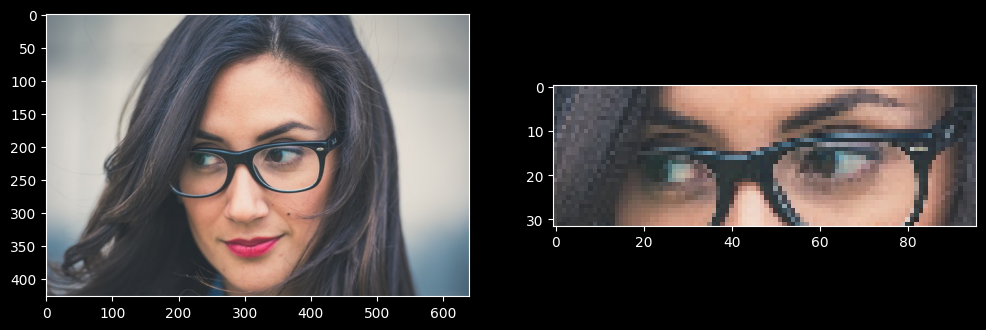

In [108]:
plt.figure(figsize=(12,12))
plt.subplot(1,2,1)
plt.imshow(testImage[:,:,::-1])
plt.subplot(1,2,2)
plt.imshow(cropped[:,:,::-1])
plt.show()

In [109]:
# Perform for a separate test image
filename = DATA_PATH + "/images/glassesDataset/no_glasses1.jpg"
testImage = cv2.imread(filename)
cropped = getCroppedEyeRegion(testImage)
testHOG = computeHOG(hog, np.array([cropped]))
testFeatures = prepareData(testHOG)
predictions = svmPredict(model, testFeatures)
print("Prediction = {}"
      .format(prediction2labels[int(predictions[0])]))

Eye Height between : 26,79
Prediction = No Glasses


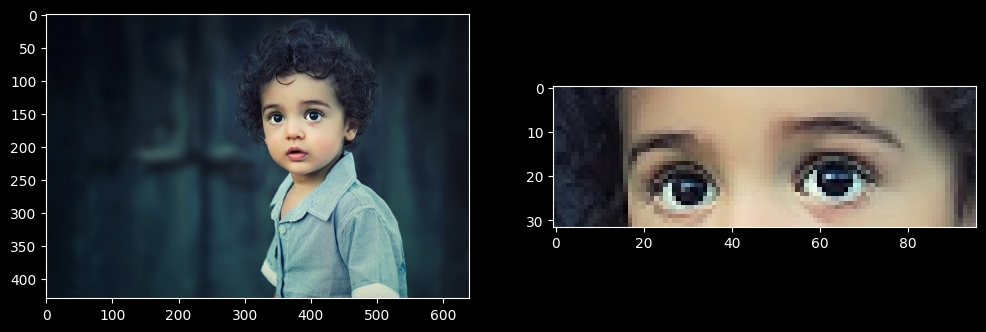

In [110]:
plt.figure(figsize=(12,12))
plt.subplot(1,2,1)
plt.imshow(testImage[:,:,::-1])
plt.subplot(1,2,2)
plt.imshow(cropped[:,:,::-1])
plt.show()

https://www.pyimagesearch.com/2014/11/10/histogram-oriented-gradients-object-detection/
https://gurus.pyimagesearch.com/lesson-sample-histogram-of-oriented-gradients-and-car-logo-recognition/
https://www.learnopencv.com/histogram-of-oriented-gradients/
https://www.learnopencv.com/image-recognition-and-object-detection-part1/